# **Import** **packages**

In [1]:
#importpackages
import datetime
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib import pyplot
from google.colab import drive
import seaborn as sns
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from tensorflow.keras.layers import GRU, SimpleRNN, Activation, LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
print(tf.test.gpu_device_name())
!nvidia-smi
!cat /proc/cpuinfo
# !cat /proc/meminfo

# **Load data**

In [3]:
#Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Open dataset from specific filepath
with open('/content/drive/MyDrive/....', 'rb') as f:
  #store in pandas dataframe
    df = pd.read_csv(f)

# **First Look at data**

In [5]:
#First look at the raw dataset
print(df.shape)
print(tabulate(df.head(), headers = 'keys', tablefmt = 'fancy_grid'))

(5433611, 6)
╒════╤══════════════════════════════════════════╤══════════════╤══════════════════╤══════════════════════════════════════════════════════════════════╤═════════════════════════════╤══════════════════════════════════════════════════════════════════╕
│    │ session_id_hash                          │ event_type   │ product_action   │ product_skus_hash                                                │   server_timestamp_epoch_ms │ hashed_url                                                       │
╞════╪══════════════════════════════════════════╪══════════════╪══════════════════╪══════════════════════════════════════════════════════════════════╪═════════════════════════════╪══════════════════════════════════════════════════════════════════╡
│  0 │ 00000005c19449b57d8d05dfc8b5474be0654032 │ pageview     │ nan              │ nan                                                              │               1544469996111 │ da99729886aff70a02733b6cd69ee7df35622d9302347ebdd9022a08b7125a

In [6]:
#info regarding the dtypes of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5433611 entries, 0 to 5433610
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   session_id_hash            object
 1   event_type                 object
 2   product_action             object
 3   product_skus_hash          object
 4   server_timestamp_epoch_ms  int64 
 5   hashed_url                 object
dtypes: int64(1), object(5)
memory usage: 248.7+ MB


In [7]:
#basic info
df.describe(include=np.object)

,session_id_hash,event_type,product_action,product_skus_hash,hashed_url
count,5433611,5433611,2514822,1886054,5433611
unique,443660,2,5,38344,256598
top,fec99c62a5c3b540191c87b4e7e8a94a397f246d,pageview,detail,29178ed23f2eecc0cc51f51bace02c52f5a326a4bea8af...,b6133a35ba149e49bcfa0f6481add6f2b88b947731ca02...
freq,7579,4565253,1640190,10327,688361


In [8]:
#shape of the dataframe
df.shape

(5433611, 6)

# **Label product events and drop columns**

In [9]:
#drop columns not needed
coldrop = [1,3,4,5]
  # columns that are dropped:
    # event_type
    # product_skus_hash
    # server_timestamp_epoch_ms
    # hashed_url

df.drop(df.columns[coldrop], axis=1, inplace=True)


In [10]:
print(tabulate(df.head(), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤══════════════════════════════════════════╤══════════════════╕
│    │ session_id_hash                          │ product_action   │
╞════╪══════════════════════════════════════════╪══════════════════╡
│  0 │ 00000005c19449b57d8d05dfc8b5474be0654032 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  1 │ 00006a0ada94a5186163a25e9ed9c94481c820d9 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  3 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ nan              │
├────┼──────────────────────────────────────────┼──────────────────┤
│  4 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ detail           │
╘════╧══════════════════════════════════════════╧══════════════════╛


In [11]:
#convert nan to view
df = df.fillna(value='view')

#convert product_action column values to numbers:
# 1 = view
# 2 = detail
# 3 = click
# 4 = remove
# 5 = purchase
# 6 = add


df["product_action"].replace({"view": 1, "detail": 2,"add": 6, "remove": 4,"purchase": 5, "click": 3}, inplace=True)

In [12]:
#check if it worked
print(tabulate(df.head(), headers = 'keys', tablefmt = 'fancy_grid'))

╒════╤══════════════════════════════════════════╤══════════════════╕
│    │ session_id_hash                          │   product_action │
╞════╪══════════════════════════════════════════╪══════════════════╡
│  0 │ 00000005c19449b57d8d05dfc8b5474be0654032 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  1 │ 00006a0ada94a5186163a25e9ed9c94481c820d9 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  3 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │                1 │
├────┼──────────────────────────────────────────┼──────────────────┤
│  4 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │                2 │
╘════╧══════════════════════════════════════════╧══════════════════╛


# **EDA**

<function matplotlib.pyplot.show>

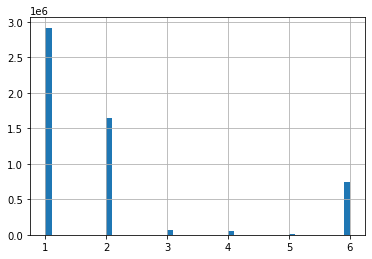

In [13]:
#show the distribution off the different events
df["product_action"].hist(bins=50)
plt.show



In [14]:
# statistics of the dataset
print("Total unique events: ", df['session_id_hash'].count())
print("Total unique sessions: ", df['session_id_hash'].nunique())
print("Total unique product actions: ", df['product_action'].nunique())

Total unique events:  5433611
Total unique sessions:  443660
Total unique product actions:  6


In [15]:
# counting the different events in the product_action column
df["product_action"].value_counts()

1    2918789
2    1640190
6     743363
3      69831
4      51512
5       9926
Name: product_action, dtype: int64

# **Add target column, trim sequences to event before add to cart if available and trim the total lenght of the sequences**

In [16]:
df2 = df

In [17]:
# create new sequence grouped by session_id_hash and sequence of product_action
sequence = df2.groupby('session_id_hash')['product_action'].apply(list)
sequence = sequence.reset_index()
#add add_to_cart target value
sequence['add_to_cart'] = sequence['product_action'].apply(lambda x: 1 if 6 in x else 0)
#remove sequences with lenght 1
sequence = sequence[sequence['product_action'].map(len)> 1]

#show result
print('Total number of records=', sequence.shape[0])
print(tabulate(sequence.head(), headers = 'keys', tablefmt = 'fancy_grid'))

Total number of records= 305004
╒════╤══════════════════════════════════════════╤══════════════════════════════════════════════════╤═══════════════╕
│    │ session_id_hash                          │ product_action                                   │   add_to_cart │
╞════╪══════════════════════════════════════════╪══════════════════════════════════════════════════╪═══════════════╡
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ [1, 1, 2, 1, 2, 1, 2]                            │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  3 │ 0000c49d1359c87f112285d63a9fc0d4c50f73b4 │ [1, 1, 1]                                        │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  5 │ 00014c4428e61aca7e64be1064d2b6cf49233cfb │ [1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1] │             0 │
├────┼──────────────────────────

In [18]:
#remove 6 from sequences
sequence['product_action']= sequence.product_action.apply(lambda row: list(filter(lambda a: a != 6, row)))

#show result
print('Total number of records=', sequence.shape[0])
print(tabulate(sequence.head(5), headers = 'keys', tablefmt = 'fancy_grid'))

Total number of records= 305004
╒════╤══════════════════════════════════════════╤══════════════════════════════════════════════════╤═══════════════╕
│    │ session_id_hash                          │ product_action                                   │   add_to_cart │
╞════╪══════════════════════════════════════════╪══════════════════════════════════════════════════╪═══════════════╡
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ [1, 1, 2, 1, 2, 1, 2]                            │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  3 │ 0000c49d1359c87f112285d63a9fc0d4c50f73b4 │ [1, 1, 1]                                        │             0 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┤
│  5 │ 00014c4428e61aca7e64be1064d2b6cf49233cfb │ [1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1] │             0 │
├────┼──────────────────────────

In [19]:
# add lenght of sequences column
sequence['lenght'] = sequence['product_action'].map(len).to_list()

#show result
print(tabulate(sequence.head(), headers = 'keys', tablefmt = 'fancy_grid'))
sequence.shape

╒════╤══════════════════════════════════════════╤══════════════════════════════════════════════════╤═══════════════╤══════════╕
│    │ session_id_hash                          │ product_action                                   │   add_to_cart │   lenght │
╞════╪══════════════════════════════════════════╪══════════════════════════════════════════════════╪═══════════════╪══════════╡
│  2 │ 00007d15aeb741b3cdd873cb3933351d699cc320 │ [1, 1, 2, 1, 2, 1, 2]                            │             0 │        7 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┼──────────┤
│  3 │ 0000c49d1359c87f112285d63a9fc0d4c50f73b4 │ [1, 1, 1]                                        │             0 │        3 │
├────┼──────────────────────────────────────────┼──────────────────────────────────────────────────┼───────────────┼──────────┤
│  5 │ 00014c4428e61aca7e64be1064d2b6cf49233cfb │ [1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1] │    

(305004, 4)

In [20]:
# store lenght in variable
length = sequence['product_action'].map(len).to_list()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


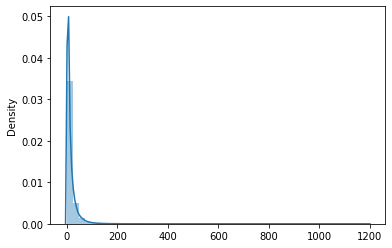

In [21]:
#plot the lenght of the sequences before trimming to lenght >= 5 and lenght =< 155
sns.distplot(length)

In [22]:
#trim. sequences to lenght > 5 and lenght < 155
sequence = sequence.drop(sequence[sequence.lenght < 5].index)
sequence = sequence.drop(sequence[sequence.lenght > 155].index)
sequence.shape

(203895, 4)

In [23]:
#drop sequence lenght column
sequence.drop(sequence.columns[3], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


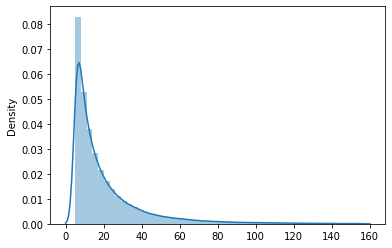

In [24]:
#plot the lenght of the sequences after trimming to lenght > 5 and lenght < 155
length = sequence['product_action'].map(len).to_list()
sns.distplot(length)

# **Pad sequences and train test and one hot encoding for LSTM, GRU and Conv1d models + balance data**

In [25]:
#padding the sequences
pad_sequence = sequence['product_action']

pad_input = tf.keras.preprocessing.sequence.pad_sequences(pad_sequence, padding="post")

print('pad_input shape=', pad_input.shape)

pad_input shape= (203895, 155)


In [26]:
# hot encoding
hot_encoded = to_categorical(pad_input, num_classes=6)
print(hot_encoded.shape)


(203895, 155, 6)


In [27]:
# define y and calculate the percentage of add to cart sessions
from collections import Counter

y = sequence['add_to_cart']

z=np.sum(y)/len(y)

print('Percentage of add to cart sessions=',z*100,"%")


Percentage of add to cart sessions= 18.481080948527428 %


In [28]:
# define function for Train Test split
def prepare_train_test_data(data,y):
  #train test split 70/30
  X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=101)

  #reshaping X_train and X_test
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],6))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],6))
  return (X_train,X_test,y_train,y_test)

In [29]:
#create train and testing data
X_train, X_test, y_train, y_test=prepare_train_test_data(hot_encoded,y)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )
print(X_val.shape,y_val.shape)


(142726, 155, 6) (142726,) (30584, 155, 6) (30584,)
(30585, 155, 6) (30585,)


In [30]:
# define oversampler
from imblearn.over_sampling import RandomOverSampler 
oversampler = RandomOverSampler(sampling_strategy=1, random_state=101)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [31]:
# oversample the data

X = X_train.reshape(len(X_train),-1)
y = y_train

X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
print(Counter(y_oversampled))
print(y_oversampled.shape)
print(X_oversampled.shape)

#shuffle so that de add to cart sessions occur random
from sklearn.utils import shuffle
X_oversampled,y_oversampled = shuffle(X_oversampled, y_oversampled, random_state=0)
z=np.sum(y_oversampled)/len(y_oversampled)
print('Percentage of add to cart sessions=',z*100,"%")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 116310, 1: 116310})
(232620,)
(232620, 930)
Percentage of add to cart sessions= 50.0 %


In [32]:
#reshape the data for the LSTM, GRU and Conv1d model
X_oversampled = X_oversampled.reshape(len(X_oversampled),155,6)
print(X_oversampled.shape)

(232620, 155, 6)


# **plot functions and eva methods**

In [33]:
from matplotlib import pyplot
def plot_history(history):
  # plot model fitting process
  print(history.history.keys())
  

  # plot train and validation loss
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

  # summarize accuracy history
  pyplot.plot(history.history['acc'])
  pyplot.plot(history.history['val_acc'])
  pyplot.title('model train acc vs validation acc')
  pyplot.ylabel('acc')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='lower right')
  pyplot.show()



def evaluate_on_test(X_test, y_test, training_model):
  #eveluate on test data
  g_preds=training_model.predict_classes(X_test)
  gaccuracy = accuracy_score(y_test, g_preds)
  print('Accuracy: %f' % gaccuracy)
  # precision tp / (tp + fp)
  gprecision = precision_score(y_test, g_preds)
  print('Precision: %f' % gprecision)
  # recall: tp / (tp + fn)
  grecall = recall_score(y_test, g_preds)
  print('Recall: %f' % grecall)
  # f1: 2 tp / (2 tp + fp + fn)
  gf1 = f1_score(y_test, g_preds)
  print('F1 score: %f' % gf1)
  # ROC and AUC
  auc_roc_0 = str(roc_auc_score(y_test, g_preds))
  print('AUC: \n' + auc_roc_0)
  
  print(classification_report(y_test, g_preds))

  cm = metrics.confusion_matrix(y_test, g_preds)

  #confusion matrix
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Auc: {0}'.format(auc_roc_0)
  plt.title(all_sample_title, size = 15);

  #roc curve
  fpr, tpr, thresholds = roc_curve(y_test, training_model.predict_classes(X_test))
  plt.figure()
  plt.plot(fpr, tpr, label='(area = %0.2f)' % roc_auc_score(y_test, g_preds))
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  

  
  

In [34]:
#compute class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(None,
                                                 np.unique(y_oversampled),
                                                 y_oversampled)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0, 1: 1.0}


In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

# **LSTM**

In [196]:
#Build the model sequence to label
def LSTM_model(neurons):
    

    model = Sequential()
    model.add(LSTM(neurons,return_sequences=False, input_shape = (155,6)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])

    return model

In [197]:
#show model
tf.keras.backend.clear_session()
training_model = LSTM_model(100)
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [198]:
#train the model
with tf.device('/gpu:0'): 
              lstm_history =       training_model.fit(X_oversampled, y_oversampled,
                    epochs=20,
                    batch_size=16,
                    callbacks=[early_stopping],
                    validation_data = (X_val,y_val),
                    class_weight=class_weights)

Epoch 1/20
14539/14539 [==============================] - 171s 12ms/step - loss: 0.6950 - recall: 0.5130 - precision: 0.5027 - acc: 0.5023 - val_loss: 0.6855 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.8161
Epoch 2/20
14539/14539 [==============================] - 169s 12ms/step - loss: 0.5988 - recall: 0.6152 - precision: 0.6445 - acc: 0.6362 - val_loss: 0.5212 - val_recall: 0.7538 - val_precision: 0.3742 - val_acc: 0.7229
Epoch 3/20
14539/14539 [==============================] - 170s 12ms/step - loss: 0.5055 - recall: 0.6850 - precision: 0.7592 - acc: 0.7343 - val_loss: 0.4536 - val_recall: 0.6633 - val_precision: 0.4517 - val_acc: 0.7899
Epoch 4/20
14539/14539 [==============================] - 169s 12ms/step - loss: 0.4958 - recall: 0.6846 - precision: 0.7654 - acc: 0.7376 - val_loss: 0.4491 - val_recall: 0.6857 - val_precision: 0.4374 - val_acc: 0.7799
Epoch 5/20
14539/14539 [==============================] - 169s 12ms/step - loss: 0.4920 - recall: 0.6892 - p

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


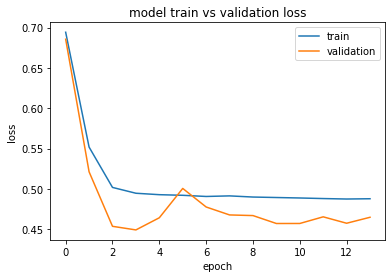

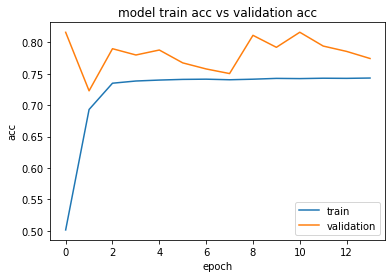

In [199]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(lstm_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.777465
Precision: 0.434228
Recall: 0.682447
F1 score: 0.530750
AUC: 
0.7406982278601941
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     24944
           1       0.43      0.68      0.53      5640

    accuracy                           0.78     30584
   macro avg       0.68      0.74      0.69     30584
weighted avg       0.83      0.78      0.79     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


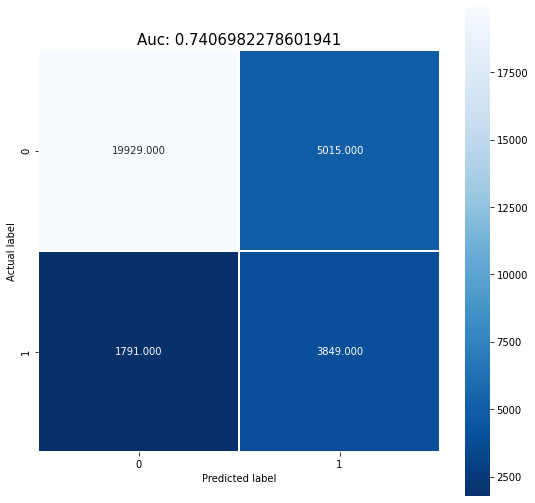

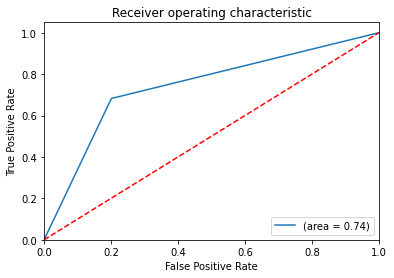

In [201]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test, y_test, training_model)

# **GRU**

In [96]:
#define GRU
def GRU_model(neurons):

    model = Sequential()
    model.add(GRU(neurons, return_sequences = False, input_shape = (155,6)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])
    return model

In [105]:
#Visualize the Model 
tf.keras.backend.clear_session()
G_model = GRU_model(100)
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               32400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 32,501
Trainable params: 32,501
Non-trainable params: 0
_________________________________________________________________


In [106]:
#Train the G_model
with tf.device('/gpu:0'): 
  g_history = G_model.fit(X_oversampled, y_oversampled,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data = (X_val,y_val),
                    class_weight=class_weights)

Epoch 1/20
3635/3635 [==============================] - 44s 11ms/step - loss: 0.5407 - recall: 0.6374 - precision: 0.7102 - acc: 0.6890 - val_loss: 0.4701 - val_recall: 0.7193 - val_precision: 0.4070 - val_acc: 0.7556
Epoch 2/20
3635/3635 [==============================] - 41s 11ms/step - loss: 0.4952 - recall: 0.6831 - precision: 0.7680 - acc: 0.7385 - val_loss: 0.5187 - val_recall: 0.7718 - val_precision: 0.3706 - val_acc: 0.7169
Epoch 3/20
3635/3635 [==============================] - 41s 11ms/step - loss: 0.4973 - recall: 0.6847 - precision: 0.7643 - acc: 0.7364 - val_loss: 0.4709 - val_recall: 0.6982 - val_precision: 0.4269 - val_acc: 0.7721
Epoch 4/20
3635/3635 [==============================] - 41s 11ms/step - loss: 0.4935 - recall: 0.6867 - precision: 0.7688 - acc: 0.7401 - val_loss: 0.4313 - val_recall: 0.5869 - val_precision: 0.5205 - val_acc: 0.8246
Epoch 5/20
3635/3635 [==============================] - 41s 11ms/step - loss: 0.4941 - recall: 0.6844 - precision: 0.7684 - acc:

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


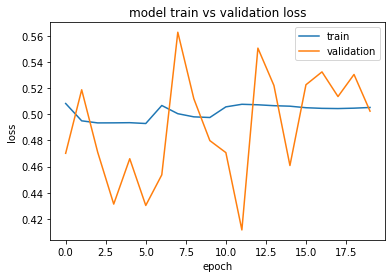

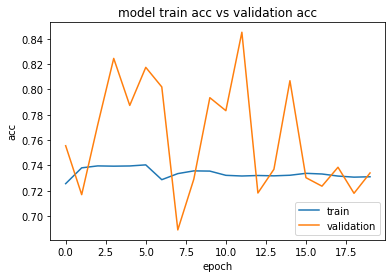

In [107]:
#plot the model curves for loss and accuracy
plot_history(g_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.731069
Precision: 0.380799
Recall: 0.732092
F1 score: 0.501001
AUC: 
0.7314646368148339
              precision    recall  f1-score   support

           0       0.92      0.73      0.82     24944
           1       0.38      0.73      0.50      5640

    accuracy                           0.73     30584
   macro avg       0.65      0.73      0.66     30584
weighted avg       0.82      0.73      0.76     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


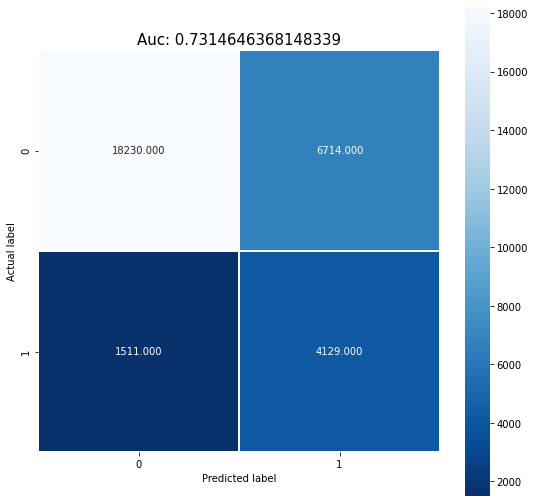

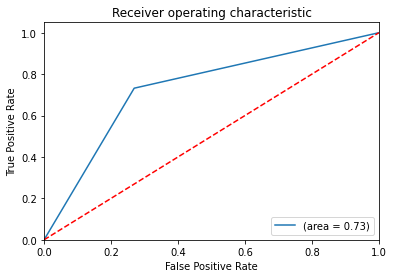

In [108]:
# Use evaluate_on_test 
evaluate_on_test(X_test, y_test, G_model)

# **Conv1D + LSTM**

In [62]:
#define GRU
def CLSTM_model(neurons):

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(155,6)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(neurons, return_sequences = False))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])
    return model

In [63]:
tf.keras.backend.clear_session()
CLSTMmodel = CLSTM_model(100)
CLSTMmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 153, 32)           608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 53,909
Trainable params: 53,909
Non-trainable params: 0
_________________________________________________________________


In [64]:
#train the model
with tf.device('/gpu:0'): 
              clstm_history =       CLSTMmodel.fit(X_oversampled, y_oversampled,
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data = (X_val,y_val),
                    class_weight=class_weights)

Epoch 1/20
7270/7270 [==============================] - 65s 9ms/step - loss: 0.6188 - recall: 0.5842 - precision: 0.6130 - acc: 0.6049 - val_loss: 0.4922 - val_recall: 0.7314 - val_precision: 0.3950 - val_acc: 0.7445
Epoch 2/20
7270/7270 [==============================] - 61s 8ms/step - loss: 0.5043 - recall: 0.6940 - precision: 0.7601 - acc: 0.7376 - val_loss: 0.4575 - val_recall: 0.6472 - val_precision: 0.4649 - val_acc: 0.7981
Epoch 3/20
7270/7270 [==============================] - 61s 8ms/step - loss: 0.4972 - recall: 0.6867 - precision: 0.7644 - acc: 0.7372 - val_loss: 0.4427 - val_recall: 0.6594 - val_precision: 0.4548 - val_acc: 0.7919
Epoch 4/20
7270/7270 [==============================] - 61s 8ms/step - loss: 0.4993 - recall: 0.6933 - precision: 0.7624 - acc: 0.7384 - val_loss: 0.4551 - val_recall: 0.6438 - val_precision: 0.4725 - val_acc: 0.8023
Epoch 5/20
7270/7270 [==============================] - 60s 8ms/step - loss: 0.4925 - recall: 0.6867 - precision: 0.7698 - acc: 0.74

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


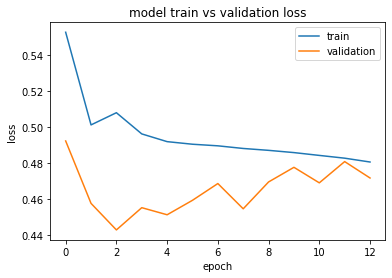

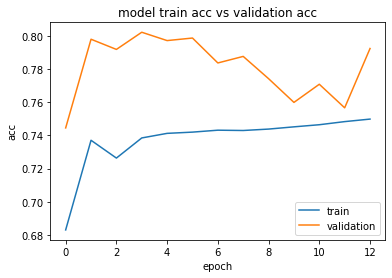

In [65]:
#plot the model curves for loss and accuracy
plot_history(clstm_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.787274
Precision: 0.447541
Recall: 0.654965
F1 score: 0.531740
AUC: 
0.7360775228710894
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     24944
           1       0.45      0.65      0.53      5640

    accuracy                           0.79     30584
   macro avg       0.68      0.74      0.70     30584
weighted avg       0.83      0.79      0.80     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


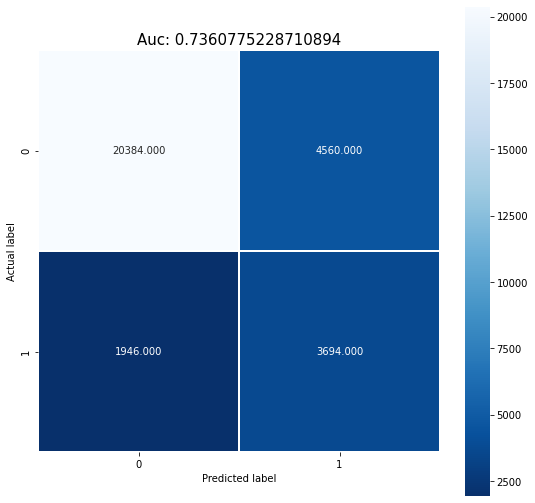

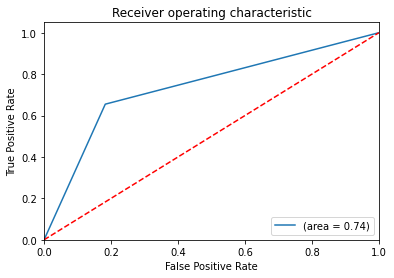

In [66]:
# Use evaluate_on_test 
evaluate_on_test(X_test, y_test, CLSTMmodel)

# **Conv1D + GRU**

In [178]:

def CGRU_model(neurons):

    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(155,6)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(neurons, return_sequences = False))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=(tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam') ), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),'acc'])
    return model

In [179]:
tf.keras.backend.clear_session()
CG_model = CGRU_model(100)
CG_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 153, 32)           608       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 76, 32)            0         
_________________________________________________________________
gru (GRU)                    (None, 100)               40200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,909
Trainable params: 40,909
Non-trainable params: 0
_________________________________________________________________


In [180]:
#Train 
with tf.device('/gpu:0'): 
  cg_history = CG_model.fit(X_oversampled, y_oversampled,
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_data = (X_val,y_val),
                    class_weight=class_weights)

Epoch 1/20
3635/3635 [==============================] - 35s 9ms/step - loss: 0.5574 - recall: 0.6283 - precision: 0.6956 - acc: 0.6778 - val_loss: 0.4575 - val_recall: 0.6641 - val_precision: 0.4610 - val_acc: 0.7954
Epoch 2/20
3635/3635 [==============================] - 31s 9ms/step - loss: 0.4946 - recall: 0.6848 - precision: 0.7681 - acc: 0.7389 - val_loss: 0.5014 - val_recall: 0.7291 - val_precision: 0.4055 - val_acc: 0.7536
Epoch 3/20
3635/3635 [==============================] - 32s 9ms/step - loss: 0.4918 - recall: 0.6869 - precision: 0.7707 - acc: 0.7407 - val_loss: 0.4841 - val_recall: 0.7025 - val_precision: 0.4277 - val_acc: 0.7723
Epoch 4/20
3635/3635 [==============================] - 32s 9ms/step - loss: 0.4905 - recall: 0.6925 - precision: 0.7693 - acc: 0.7418 - val_loss: 0.4981 - val_recall: 0.7337 - val_precision: 0.4029 - val_acc: 0.7510
Epoch 5/20
3635/3635 [==============================] - 32s 9ms/step - loss: 0.4888 - recall: 0.6849 - precision: 0.7725 - acc: 0.74

dict_keys(['loss', 'recall', 'precision', 'acc', 'val_loss', 'val_recall', 'val_precision', 'val_acc'])


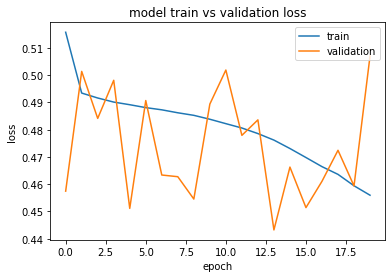

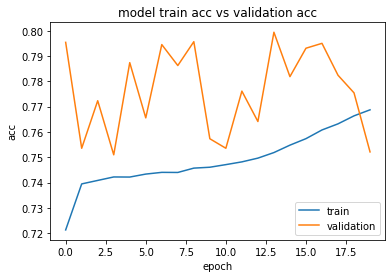

In [181]:
#plot the model curves for loss and accuracy
plot_history(cg_history)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.745226
Precision: 0.391707
Recall: 0.690071
F1 score: 0.499743
AUC: 
0.7238840819037481
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     24944
           1       0.39      0.69      0.50      5640

    accuracy                           0.75     30584
   macro avg       0.65      0.72      0.66     30584
weighted avg       0.82      0.75      0.77     30584



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


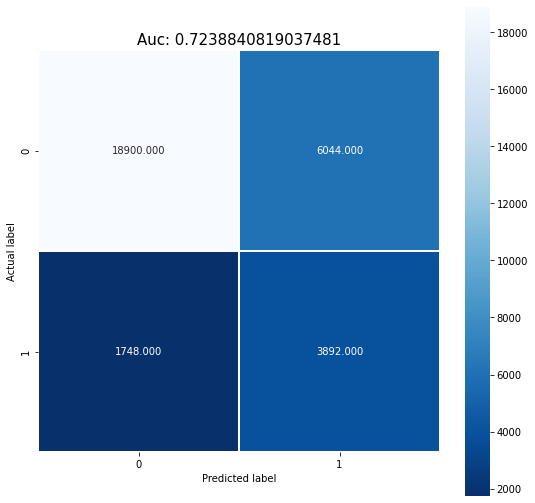

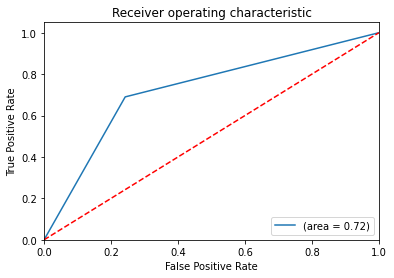

In [182]:
# Use evaluate_on_test 
evaluate_on_test(X_test, y_test, CG_model)

# **Train test split Random forests and Logistic regression + balance data**

In [109]:
y = np.array(sequence['add_to_cart'])

In [110]:
# define function for Train Test split
def prepare_train_test_data(data,y):
  #train test split 70/30
  X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)

  #reshaping X_train and X_test
  X_train = X_train.reshape((X_train.shape[0],  X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0],  X_test.shape[1]))
  return (X_train,X_test,y_train,y_test)

In [111]:
X_train, X_test, y_train, y_test=prepare_train_test_data(np.array(pad_input),y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(142726, 155) (142726,) (61169, 155) (61169,)


In [112]:
# define oversampler
from imblearn.over_sampling import RandomOverSampler 
oversampler = RandomOverSampler(sampling_strategy=1, random_state=101)

In [113]:
# oversample the data

X = X_train
y = y_train

X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
print(Counter(y_oversampled))
print(y_oversampled.shape)
print(X_oversampled.shape)

#shuffle so that de add to cart sessions occur random
from sklearn.utils import shuffle
X_train,y_train = shuffle(X_oversampled, y_oversampled, random_state=0)
z=np.sum(y_train)/len(y_train)
print('Percentage of add to cart sessions=',z*100,"%")

Counter({0: 116255, 1: 116255})
(232510,)
(232510, 155)
Percentage of add to cart sessions= 50.0 %


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# **Random forests**

In [122]:
rfc1=RandomForestClassifier(random_state=101, n_jobs= -1, n_estimators= 100)

In [123]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=101, verbose=0,
                       warm_start=False)

In [124]:
probab_pred = rfc1.predict_proba(X_test)
predictions = rfc1.predict(X_test)
score = rfc1.score(X_test, y_test)

print(score)

0.8270529189622194


In [125]:
cm = metrics.confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     49958
           1       0.53      0.48      0.50     11211

    accuracy                           0.83     61169
   macro avg       0.71      0.69      0.70     61169
weighted avg       0.82      0.83      0.82     61169



AUC: 
0.691708440439262


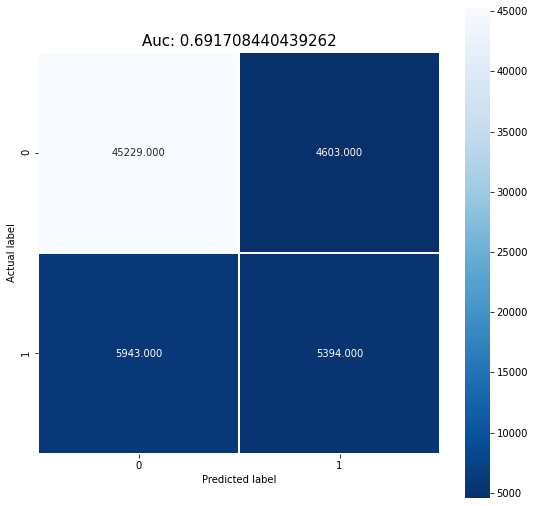

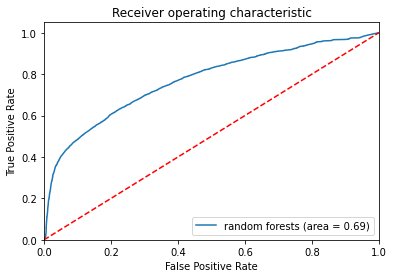

In [45]:
auc_roc_0 = str(roc_auc_score(y_test, predictions))
print('AUC: \n' + auc_roc_0)


cm = metrics.confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Auc: {0}'.format(auc_roc_0)
plt.title(all_sample_title, size = 15);

logit_roc_auc = roc_auc_score(y_test, rfc1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='random forests (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


# **logistic regression**

In [140]:
logisticRegr = LogisticRegression(max_iter = 1000 , solver='saga', verbose =1, n_jobs=-1, C = 1 )

In [141]:
logisticRegr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 481 epochs took 232 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.9min finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [142]:
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)

print(score)

0.7110791413951512


In [143]:
cm = metrics.confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80     49958
           1       0.35      0.71      0.47     11211

    accuracy                           0.71     61169
   macro avg       0.64      0.71      0.64     61169
weighted avg       0.81      0.71      0.74     61169



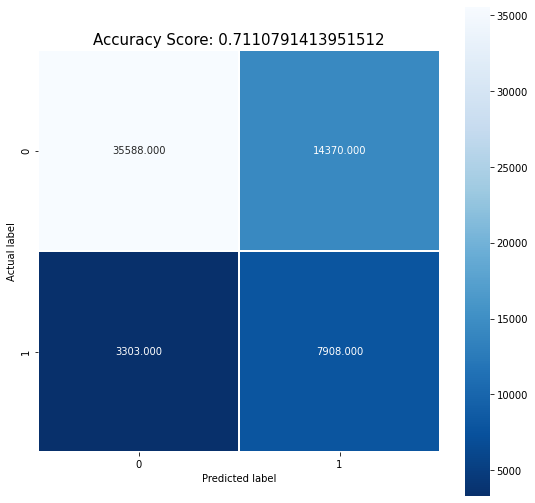

In [144]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

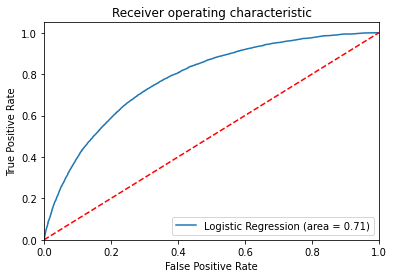

In [145]:

logit_roc_auc = roc_auc_score(y_test, logisticRegr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [67]:
auc_roc_0 = str(roc_auc_score(y_test, predictions))
print('AUC: \n' + auc_roc_0)

AUC: 
0.7105838869922847
